In [1]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

import numpy as np
import matplotlib.pyplot as plt

import torch

### **Load data for preprocessing**

In [38]:
raw_stock_data = pd.read_csv('data/SP500_stock_prices_cleaned.csv', index_col=0, parse_dates=True)
raw_stock_data.head()

,Ticker,Open,Low,High,Close,Volume,Sector
Date,,,,,,,
2016-01-04,MMM,148.050003,145.399994,148.320007,146.820007,3277200,Industrials
2016-01-05,MMM,146.820007,145.610001,147.500000,147.460007,2688100,Industrials
2016-01-06,MMM,145.589996,143.419998,145.759995,144.490005,2997100,Industrials
2016-01-07,MMM,142.520004,140.630005,143.130005,140.970001,3553500,Industrials
2016-01-08,MMM,141.360001,140.220001,142.500000,140.490005,2664000,Industrials


In [39]:
stock_tickers = pd.Series(raw_stock_data.Ticker.unique())

period = raw_stock_data.index.unique()
period_length = period.__len__()

In [40]:
log_stock_data = raw_stock_data.copy()
log_stock_data['Volume'].apply(lambda x: 0 if x <= 0 else np.log(x)) # because of volume-values of zero
numerical_columns = ['Open', 'High', 'Low', 'Close'] # volume taken care of previously
print(raw_stock_data[raw_stock_data[numerical_columns] == 0].count())
log_stock_data[numerical_columns] = np.log(raw_stock_data[numerical_columns])
log_stock_data.head()

Ticker    0
Open      0
Low       0
High      0
Close     0
Volume    0
Sector    0
dtype: int64


,Ticker,Open,Low,High,Close,Volume,Sector
Date,,,,,,,
2016-01-04,MMM,4.997550,4.979489,4.999372,4.989207,3277200,Industrials
2016-01-05,MMM,4.989207,4.980932,4.993828,4.993557,2688100,Industrials
2016-01-06,MMM,4.980794,4.965777,4.981961,4.973210,2997100,Industrials
2016-01-07,MMM,4.959482,4.946132,4.963753,4.948547,3553500,Industrials
2016-01-08,MMM,4.951310,4.943213,4.959342,4.945136,2664000,Industrials


In [41]:
# the log returns is susceptible to values of 1 since it results in a log of 0, meaning infinity returns...
# we create a small work around

# def ThreeMonthReturn(closing_price, lags=63, log=False): 
#     offset = 0.0001
#     return closing_price.pct_change(lags) if log == False else closing_price.apply(lambda x: np.log(x + offset)).pct_change(lags)

def n_lag_return(price, lags=63):
    return price - price.shift(-lags)

## **The nature of the data**
Here we will ponder how to process the data and how it should be treated to avoid accidentally *feeding* knowlege of the future into each prediction. We also need to come up with the aligning of data. Our goal is basically to predict the statement _"if I buy now, then sell 3 months later, what would be my returns"_. That means, the return data for the return in 3 months has to be aligned to the day we ask the question a.k.a timestep <span style="color:#ff8b4d">_t_</span>.  
We now have to ask, what data does the model need in order to make _n_-day forecasts? It needs the same type of data, so we have to feed it 3months returns as well. We have to be careful when using data though, because there might be info from the future bleeding into the model if we dont truncate the used data properly.  
Imagine we have the column with 3month returns; each row corresponds to a day where we asked "our question", and the answer is only here because we have all the data available. Therefore data that is in the range of <span style="color:#ff8b4d">_t_<sub>-3months</sub></span> to <span style="color:#ff8b4d">_t_</span> is forbidden to use, since it relies on data that is in the future range, <span style="color:#ff8b4d">_t_</span> to <span style="color:#ff8b4d">_t_<sub><b>+</b>3months</sub></span>  
This means returns data used for our model has to be _n_ days further back from _t_ than you would assume.  

Now we note that we can still use the closing price, volume and so on for all the normal days up to the time-step <span style="color:#ff8b4d">_t_</span>. This has to be implemented in the creation of the training and test dataset, not necessarily in the dataset csv itself. The creation of the sequences are easier to "line up" correctly since that just has each prediction's batch/sequence it uses saved in the same row as itself.  

It would mean a prediction for the return in 3 months at time-step <span style="color:#ff8b4d">_t_</span> would have the sequence of returns from <span style="color:#ff8b4d">_t_<sub>-6months</sub></span> to <span style="color:#ff8b4d">_t_<sub>-3months</sub></span> saved in the first dimension, the length of it still being 62. It will however have the _closing price_, _volume_ and so on up untill the time-step <span style="color:#ff8b4d">_t_</span>
  

<span style="color:#ff8b4d">wat</span>
<span style="color:#3be3ca">wat</span>
<span style="color:#e9677b">wat</span>

### **Goals of preprocessing**
We want to add a few extra columns to the dataset, namely a target that is a percentual return 
for the price 3 months in the future (approximately 62-steps-ahead forecast). 
It is crucial to line these up correctly, and we believe that would mean having the return not on the
date you learn what the return is but shift it backwards so that at a date, you ask "if I buy now, then 
sell 3 months later, what would be my return". \
This question is the one we want the LSTM to answer, and therefore it has to be lined up with the data being available up to that date  

In addition we use log returns in order to gain numerical stability and a time-additive property instead of the multiplicatave of simple returns.

In [25]:
### Only for 1 stock to simplify first.
aapl_stock_data = raw_stock_data[raw_stock_data['Ticker'] == 'AAPL'].copy()
aapl_stock_data.head(5)

,Ticker,Open,Low,High,Close,Volume,Sector
Date,,,,,,,
2016-01-04,AAPL,25.652500,25.500000,26.342501,26.337500,270597600,Information Technology
2016-01-05,AAPL,26.437500,25.602501,26.462500,25.677500,223164000,Information Technology
2016-01-06,AAPL,25.139999,24.967501,25.592501,25.174999,273829600,Information Technology
2016-01-07,AAPL,24.670000,24.107500,25.032499,24.112499,324377600,Information Technology
2016-01-08,AAPL,24.637501,24.190001,24.777500,24.240000,283192000,Information Technology


In [41]:
# 3 month, approx 62 datapoints return calculated on the closing price

# aapl_stock_data['simple_return_3m'] = ThreeMonthReturn(aapl_stock_data['Close'])

aapl_stock_data['log_return_3m'] = ThreeMonthReturn(aapl_stock_data['Close'], log=True)

In [42]:
aapl_stock_data.tail(5)

,Ticker,Open,Low,High,Close,Volume,Sector,log_return_3m
Date,,,,,,,,
2020-03-26,AAPL,61.630001,61.590000,64.669998,64.610001,252087200,Information Technology,-0.026827
2020-03-27,AAPL,63.187500,61.762501,63.967499,61.935001,204216800,Information Technology,-0.036613
2020-03-30,AAPL,62.685001,62.349998,63.880001,63.702499,167976400,Information Technology,-0.031382
2020-03-31,AAPL,63.900002,63.000000,65.622498,63.572498,197002000,Information Technology,-0.033499
2020-04-01,AAPL,61.625000,59.782501,62.180000,60.227501,176218400,Information Technology,-0.051063


In [23]:
def ReturnsPlot(return_data, title, y_labels=[], second_data=None, fig_kwargs={}, grid=False, max_return=False):

# double axis plot using closing price and volumne traded on second axis.
# Closing price in blue and volume in orange
# dates should be every 6 months

    if len(y_labels) == 1:
        y_labels = [y_labels]

    fig, ax1 = plt.subplots(**fig_kwargs)

    color = 'tab:blue'
    ax1.set_xlabel('Date')
    ax1.set_ylabel(y_labels[0], color=color)
    ax1.plot(return_data, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.axhline(y=0, color='tab:red', linestyle='--', alpha=0.25, linewidth=2)

    # show two vertical lines where one is the max 3 month return point, and the other is three months before that
    if max_return:
        max_3month_return_date = return_data.idxmax()
        ax1.axvline(x=max_3month_return_date, color='black', linestyle='--', alpha=0.2)
        ax1.axvline(x=max_3month_return_date + pd.Timedelta(days=-90), color='black', linestyle='--', alpha=0.2)

        ax1.axvspan(max_3month_return_date + pd.Timedelta(days=-90), 
                    max_3month_return_date, hatch='///',
                    color='green', alpha=0.1)

    if grid:
        # Make a grid that has vertical lines on every 3 months starting from the first date
        start_date = return_data.index[0]
        end_date = return_data.index[-1]
        date_range = pd.date_range(start_date - pd.Timedelta(days=3), end_date, freq='3MS')
        for date in date_range:
            ax1.axvline(x=date, color='black', linestyle='--', alpha=0.25)

    if second_data is not None:
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        color = 'tab:orange'
        ax2.set_ylabel(y_labels[1], color=color)  # we already handled the x-label with ax1
        ax2.plot(second_data, color=color, alpha=0.5)
        ax2.tick_params(axis='y', labelcolor=color)
    
    # plt.legend()
    fig.tight_layout()
    plt.title(title)
    plt.show()

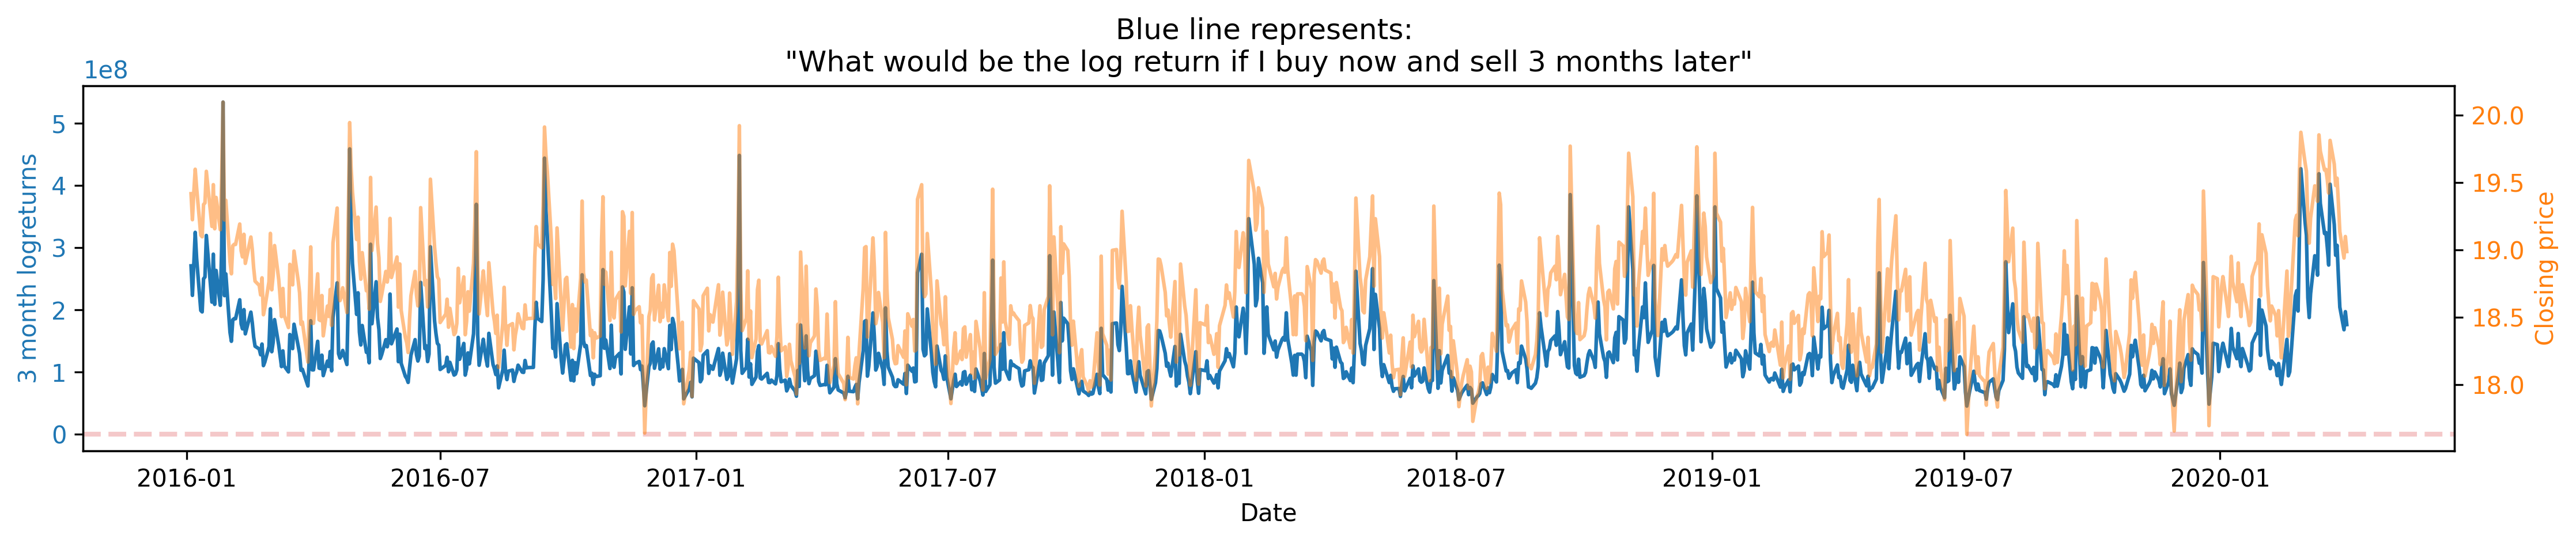

In [27]:

ReturnsPlot(aapl_stock_data['Volume'], 
            'Blue line represents: \n"What would be the log return if I buy now and sell 3 months later"',
            y_labels=['3 month logreturns', 'Closing price'],
            second_data=np.log(aapl_stock_data['Volume']),
            fig_kwargs={'figsize': (15, 3), 'dpi': 300},
            grid=False,
            max_return=False,)

#### **Next step: create the sequence for use in LSTM**
We need a tensor with 3 dimensions; \
**One** for all samples (sequences leading up to our prediction) which is each day of the time period. \
**One** for the number of time steps we use to make the one prediction. Going with 3 months, we have approximately 63 datapoints, since weekends and holidays arent trading days. (~21 working days a month). \
**The** last dimension is the number of features(explanatory variables) that we use in the model.

In [38]:
def CreateSequences(data, look_back=63, horizon=63, target_name='log_return_3m'):
    """
    data: dataframe of all financial data, features and target
    look_back: how many days of data to use as features
    horizon: how many days in the future to predict
    target_name: name of the target column in the dataframe

    return: outputs feature sequences of length look_back for each day in the data, 
    starting from the look_back'th day (63nd day e.g.)
    target is the return at the horizon'th day (63 days later e.g.)
    """
    
    # check if any column has non-numerical values and if there are, 
    # continue with a warning and dropping the offending columns
    if data.applymap(np.isreal).all().all() == False:
        print("WARNING: Non-numerical values detected in dataframe. Dropping columns with non-numerical values.")
        data = data.select_dtypes(exclude=['object'])
    
    features = []
    target = []

    for timestep in range(look_back, len(data) - horizon):
        features.append(data.iloc[timestep-look_back:timestep])
        target.append(data[target_name].iloc[timestep+horizon])
    
    return torch.tensor(np.array(features)), torch.tensor(np.array(target))

In [46]:
X, y = CreateSequences(aapl_stock_data, 63, 63) # use 3 month log returns to predict log returns in 3 month
X.shape, y.shape

(torch.Size([945, 62, 6]), torch.Size([945]))

### **Now we do it for all the stocks**

In [99]:
# we want the 3 month return for each ticker, and here we concat them together so they can create the new column next cell
# simple_returns_series = pd.concat([ThreeMonthReturn(raw_stock_data[raw_stock_data['Ticker'] == ticker]['Close'].copy()) for ticker in stock_tickers])

log_returns_series = pd.concat([ThreeMonthReturn(raw_stock_data[raw_stock_data['Ticker'] == ticker]['Close'].copy(), log=True) for ticker in stock_tickers])

In [101]:
# raw_stock_data['simple_return_3m'] = simple_returns_series

raw_stock_data['log_return_3m'] = log_returns_series

In [ ]:
# checking for inf values
maxx = 0

for ticker in stock_tickers:
    maxx1 = raw_stock_data[raw_stock_data.Ticker == ticker]['log_return_3m'].max().max()
    if maxx1 > maxx:
        maxx = maxx1
        print(maxx, ticker)

#### **Functions for creating feature and target tensors**

In [9]:
## We need to make data splits multiple times in the model since we use walk forward validation
## creating a function to split data at a specific date? Has to match with 3 month horizon

def SplitData(data, split_idx):
    """
    data: tensors of features and targets
    split_idx: index to split the data at (test set will be inclusive of this index)
    
    returns: train and test sets
    
    training set is as long as possible
    while the test is 3 months long
    """

    # using index, we split the tensor into train and test
    train, test = data.split([split_idx, data.shape[0]-split_idx], dim=0)

    return train, test[0:63]

In [96]:
period.get_loc('2019-02-05')
if pd.Timestamp('2019-02-05') in raw_stock_data.index:
    print(raw_stock_data.index.get_loc(pd.Timestamp('2019-02-05')))

if pd.Timestamp('2019-02-05') in period:
    print(period)

[False False False ... False False False]
DatetimeIndex(['2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07',
               '2016-01-08', '2016-01-11', '2016-01-12', '2016-01-13',
               '2016-01-14', '2016-01-15',
               ...
               '2020-03-19', '2020-03-20', '2020-03-23', '2020-03-24',
               '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-30',
               '2020-03-31', '2020-04-01'],
              dtype='datetime64[ns]', name='Date', length=1069, freq=None)


In [83]:
def FindNearestDateIndex(date, period):
    """
    data: date-str of YYYY-MM-DD
    df: dataframe with datetime index

    returns: index of the nearest date in the future
    """
    date = pd.Timestamp(date)

    # If the date exists in the index, return its index
    if date in df.index:
        return df.index.get_loc(date)

    # If the date does not exist in the index, find the next closest date in the future
    mask = df.index > date
    if mask.any():
        return mask.argmax()
    
    # If no future date is found, raise an error
    raise ValueError("No available date found in the future.")

In [82]:
def DataFrame_to_Tensors(data, split_date, look_back=63, horizon=63):
    """
    data: dataframe of features and targets
    look_back: length of each sequence
    horizon: how far in the future to predict
    
    returns: dictionary of train and test sets
    """
    
    # find the splitting index to apply to the tensors from the dataframe
    # we subtract the look_back since that portion of data dissapears
    # when we create sequences of look_back length

    features, target = CreateSequences(data, look_back=look_back, horizon=horizon)
    
    return features, target

In [80]:
def SplitTrainTest(features, target, split_date, period, look_back=None):
    """
    features: tensor of features
    target: tensor of targets
    split_date: date to split the data at
    period: datetime object for financial period of stocks
    look_back: length of each sequence

    returns: dictionary of train and test sets
    """

    split_index = FindNearestDateIndex(split_date, period) - look_back

    if look_back == None: look_back = features.shape[1] # find sequence length

    train_features, test_features = SplitData(features, split_idx=split_index)
    train_targets, test_targets = SplitData(target, split_idx=split_index)
    
    return {'train_features': train_features, 'train_targets': train_targets,
            'test_features': test_features, 'test_targets': test_targets}

In [53]:
FindNearestDateIndex('2019-10-01', raw_stock_data[raw_stock_data['Ticker'] == 'MMM'])

942

In [81]:
for t in stock_tickers[0:1]:
    features, target = DataFrame_to_Tensors(raw_stock_data[raw_stock_data['Ticker'] == t], 
                                                         split_date='2019-10-01', look_back=63, horizon=63)
    dicc = SplitTrainTest(features, target, split_index=split_index)
    print(features.shape, target.shape)
    print(dicc['train_features'].shape, dicc['train_targets'].shape)

torch.Size([943, 63, 6]) torch.Size([943])
torch.Size([879, 63, 6]) torch.Size([879])


In [26]:
for t in stock_tickers:
    if raw_stock_data[raw_stock_data['Ticker'] == t].__len__() < 1069:
        print(t, raw_stock_data[raw_stock_data['Ticker'] == t].__len__())



CARR 10
CDAY 487
CTVA 216
DOW 262
FTV 943
FOXA 268
FOX 267
HWM 859
IR 727
INVH 797
LW 852
MRNA 331
OTIS 10
VICI 566


In [236]:
# three months back bcuz of corona
# another three for making sequences
# another three for splitting data into train and test
aapl_stock_data.shape[0] - 63 - 63 - 63

880

In [48]:
ticker_seq_dict = {}

for ticker in stock_tickers:
    df = raw_stock_data[raw_stock_data['Ticker'] == ticker].drop(columns=['Ticker', 'Sector']).copy()
    ticker_seq_dict[ticker] = DataFrame_to_Tensors(df, split_date='2019-10-01')

"""
TODO: When we have tested our model and are moving on to the next step, we might want to just concatenate the 
train and test sets together, then train on the whole set and only creating/splitting the new test set.
This way we dont have to create all tensors from scratch each time.

TODO: we can move it to 2 functions. One that converts correctly to tensors and still creates sequences
and then one that can split the data correctly at some specified date. This way we can just split the data each time we want to test
instead of creating all sequences again. Also makes it much faster since its just splitting.
"""

In [251]:
# create the data sequences for each stock ticker. Save it into a dictionary
train_seq_dict = {}
for ticker in stock_tickers:
    df = train_df[train_df['Ticker'] == ticker].drop(columns=['Ticker', 'Sector'])
    features, targets = CreateSequences(df, 62, 62)
    sequences_dict = {'features': features, 'targets': targets}
    train_seq_dict[ticker] = sequences_dict


test_seq_dict = {}
for ticker in stock_tickers:
    df = test_df[test_df['Ticker'] == ticker].drop(columns=['Ticker', 'Sector'])
    features, targets = CreateSequences(df, 62, 62)
    sequences_dict = {'features': features, 'targets': targets}
    test_seq_dict[ticker] = sequences_dict

train_seq_dict['AAPL'][0].shape, train_seq_dict['AAPL'][1].shape, test_seq_dict['AAPL'][0].shape, test_seq_dict['AAPL'][1].shape

(torch.Size([945, 62, 7]), torch.Size([945, 7]))

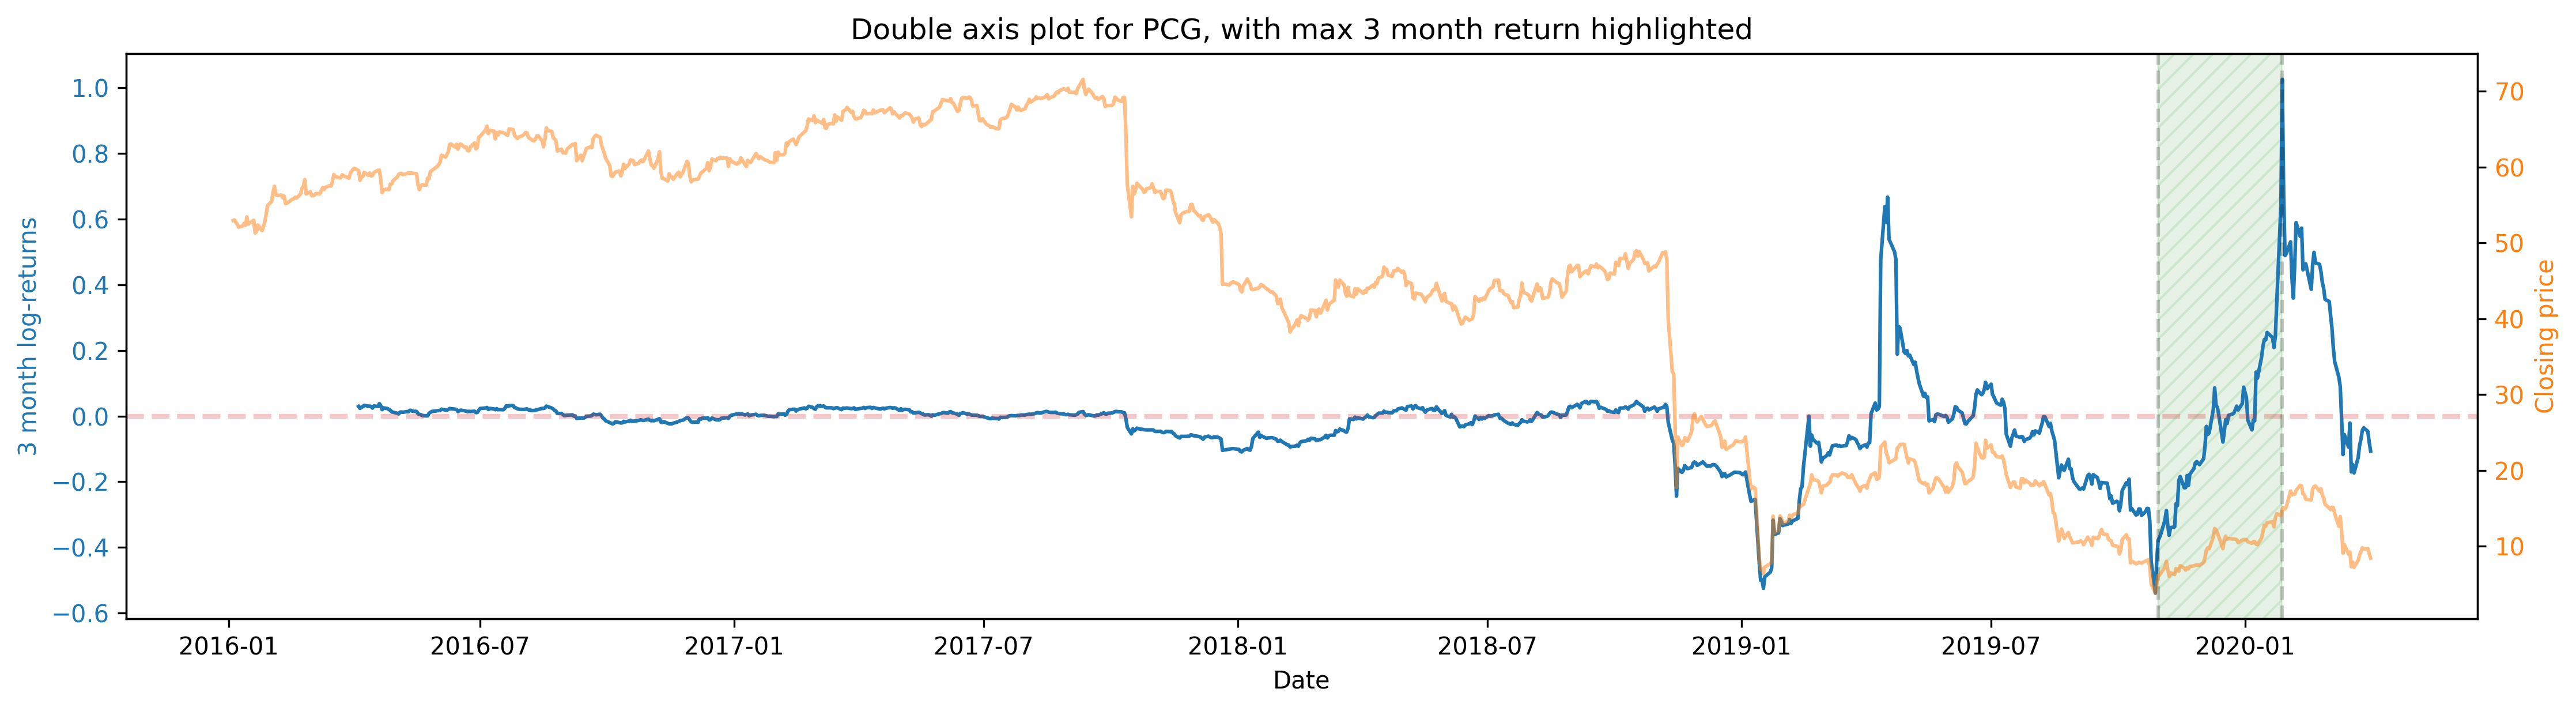

In [144]:
ReturnsPlot(raw_stock_data[raw_stock_data['Ticker'] == 'PCG']['log_return_3m'],
            'Double axis plot for PCG, with max 3 month return highlighted',
            y_labels=['3 month log-returns', 'Closing price'],
            second_data=raw_stock_data[raw_stock_data['Ticker'] == 'PCG']['Close'],
            fig_kwargs={'figsize': (15, 4), 'dpi': 300},
            grid=False,
            max_return=True,)

### **Save the new dataset for usage in modelling with LSTM**

In [102]:
# save the dataframe to csv
raw_stock_data.to_csv('data/SP500_stock_prices_cleaned_with_3month_return.csv')

In [ ]:
# save the torch tensors for use in the model script
